In [1]:
import numpy as np
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import cv2
import random

import scipy.ndimage as ndi

import skimage
from skimage import transform as tf

from sklearn.metrics import average_precision_score

from scipy import ndimage
import skimage.filters as filters

from scipy.optimize import minimize_scalar

import os

from tqdm import tqdm

In [2]:
def load_data(data_path, model, evaluation_set):
    """
    Load RGB images, ground truth masks, and prediction masks

    Parameters:
    - data_path: path to the data
    - model: the model to be loaded, one of ['dataset_448_outlines_real', 'dataset_448_outlines_fake_noDT', 'dataset_448_outlines_fake']
    - evaluation_set: the set the model was evaluated on, either 'fake' or 'real'
    """
    model_path = os.path.join(data_path, model, evaluation_set)

    # Load RGB images
    rgb_data = []
    for filename in sorted(os.listdir(model_path)):
        if not filename.endswith("img.png"):
            continue
        image_path = os.path.join(model_path, filename)
        image = cv2.imread(image_path)
        rgb_data.append(image)

    # Load prediction masks
    pred_data = []
    for filename in sorted(os.listdir(model_path)):
        if not filename.endswith("predmask.png"):
            continue
        image_path = os.path.join(model_path, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = image.astype(float) / 255.0
        pred_data.append(image)

    # Load ground truth masks
    gt_data = []
    for filename in sorted(os.listdir(model_path)):
        if not filename.endswith("truemask.png"):
            continue
        image_path = os.path.join(model_path, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = image.astype(float) / 255.0
        gt_data.append(image)
    
    return np.array(rgb_data), np.array(pred_data), np.array(gt_data)

In [3]:
def plot_datasets(gt, prs, n=5):
    num_models = len(prs)
    fig, axs = plt.subplots(nrows=num_models + 1, ncols=n, figsize=(15, 3*num_models), facecolor='black')
    fig.subplots_adjust(hspace=0, wspace=0.02)

    for i in range(n):
        axs[0, i].imshow(1-gt[i], cmap='gray')
        axs[0, i].axis('off')
        for j in range(num_models):
            axs[j + 1, i].imshow(1-prs[j][i], cmap='gray')
            axs[j + 1, i].axis('off')

    plt.show()

In [4]:
def evaluate_at_matching_distance(gt, pr, matching_distance, n_thresholds=10, average = 'macro'):
    
    # Create a square structuring element
    struct_elem = np.ones((1, 2 * matching_distance + 1, 2 * matching_distance + 1), dtype=bool)

    # Perform dilation on the edge map
    if matching_distance > 0:
        gt_dilate = ndimage.binary_dilation(gt, structure=struct_elem)
    else:
        gt_dilate = gt
    
    thresholds = np.linspace(0, 1, num=n_thresholds)

    # ODF calculation
    f1_scores = []
    for t in thresholds:
        pred_bin = (pr > t).astype(int)
        gt_matching = np.copy(gt)
        gt_matching[np.logical_and(pred_bin == gt_dilate, pred_bin == 1)] = 1 
        f1_scores.append(f1_score(gt_matching.ravel(), pred_bin.ravel(), average=average))
    maxarg = np.argmax(f1_scores)
    odf = f1_scores[maxarg]
    best_threshold = thresholds[maxarg]

    # OIF calculation
    best_f1_scores = []
    for i in range(pr.shape[0]):
        f1_scores = []
        for t in thresholds:
            pred = (pr[i] > t).astype(int)
            gt_matching = np.copy(gt[i])
            gt_matching[np.logical_and(pred == gt_dilate[i], pred == 1)] = 1 
            f1_scores.append(f1_score(gt_matching.ravel(), pred.ravel(), average=average))
        best_f1_scores.append(np.max(f1_scores))
    oif = np.mean(best_f1_scores)

    pred_bin = (pr > best_threshold).astype(int)
    gt_matching = np.copy(gt)
    gt_matching[np.logical_and(pred_bin == gt_dilate, pred_bin == 1)] = 1 

    # AP
    ap = average_precision_score(gt_matching.ravel(), pr.ravel(), average=average)

    return odf, oif, ap, best_threshold

In [5]:
def plot_results(datasets, matching_distances, dataset_labels=None):
    fig, ax = plt.subplots(1, 3, figsize=(9, 3))
    ax = ax.ravel()
    
    if dataset_labels == None:
        dataset_labels = np.arange(len(datasets))

    for i, dataset in enumerate(datasets):
        gt, pr = dataset
        odfs = []
        oifs = []
        aps = []
        for matching_distance in tqdm(matching_distances):
            odf, oif, ap, _ = evaluate_at_matching_distance(gt, pr, matching_distance)
            odfs.append(odf)
            oifs.append(oif)
            aps.append(ap)
        
        ax[0].plot(matching_distances, oifs, label=dataset_labels[i])
        ax[1].plot(matching_distances, odfs, label=dataset_labels[i])
        ax[2].plot(matching_distances, aps, label=dataset_labels[i])
    
    ax[0].set_title("OIF")
    ax[1].set_title("ODF")
    ax[2].set_title("AP")

    for i in range(3):
        ax[i].set_xlabel("Matching Distance (pixels)")
        ax[i].legend()
        ax[i].set_ylim([0,1])
    plt.show()

In [8]:
# Example usage
data_path = r"C:\Users\appel\Desktop\image_synthesis"
models = ['dataset_448_outlines_real', 'dataset_448_outlines_fake_noDT', 'dataset_448_outlines_fake']
evaluation_set = ['fake', 'real'][1]

img1, pr1, gt1 = load_data(data_path=data_path, model=models[0], evaluation_set=evaluation_set)
img2, pr2, gt2 = load_data(data_path=data_path, model=models[1], evaluation_set=evaluation_set)
img3, pr3, gt3 = load_data(data_path=data_path, model=models[2], evaluation_set=evaluation_set)
dataset_labels = models

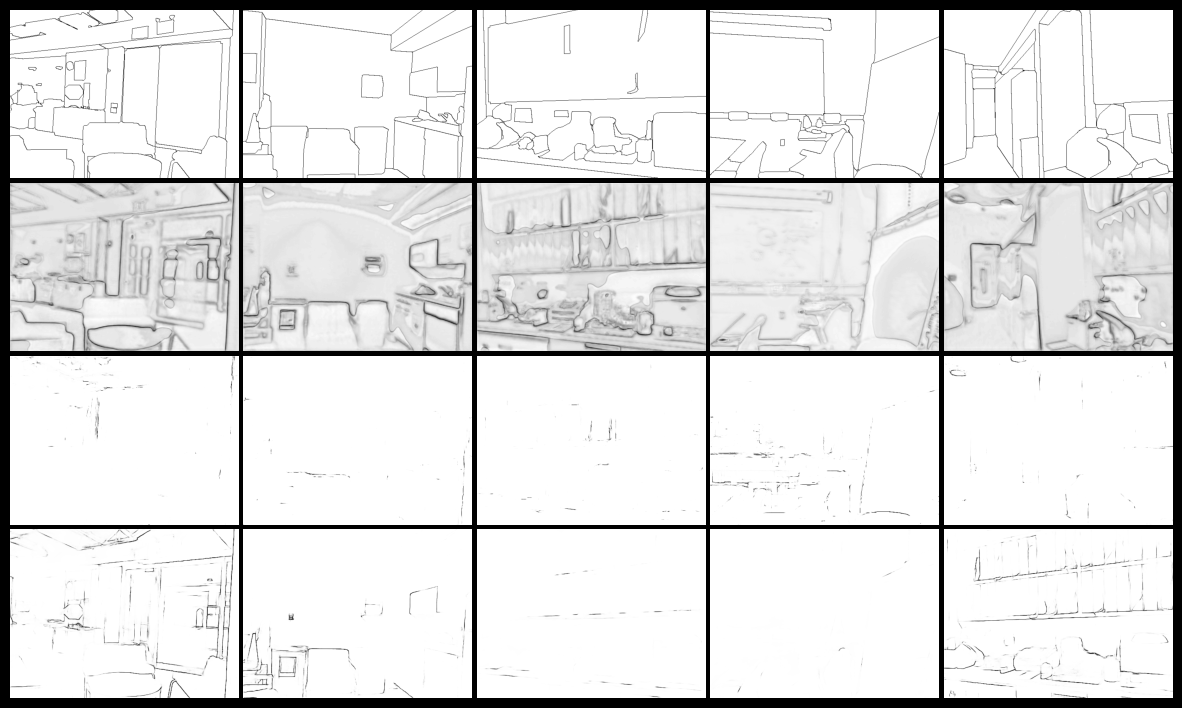

In [9]:
plot_datasets(gt1, [pr1, pr2, pr3])

100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


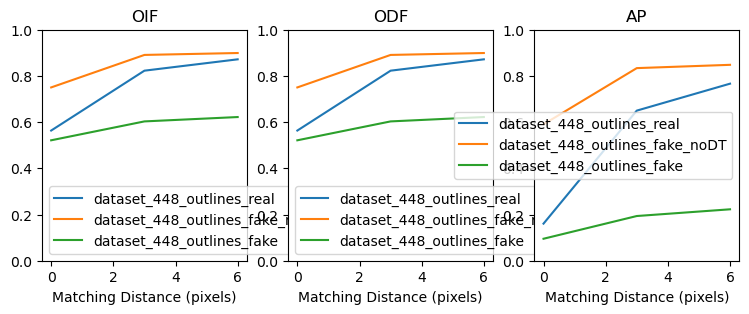

In [80]:
matching_distances = [0, 3, 6]
n = 1

plot_results(datasets=[(gt1[:n], pr1[:n]), (gt2[:n], pr2[:n]), (gt3[:n], pr3[:n])], matching_distances=matching_distances, dataset_labels=dataset_labels)